# **Modelling and Evaluation**

## Objectives

* This notebook aims to answer Hypothesis 4:

The Base model created in the last notebook will be compared to a model using the softmax activation function in the output layer. 


## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings: outputs/v1/image_shape.pkl
* Base model: outputs/v1/mildew_detector_model.h5

## Outputs

* Image augmentation.
* Machine learning model creation and training.
* Saved model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Conclusion

The hypothesis was neither validated nor invalidated. 

---

# Prepare Data Directories

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/Users/alitapantea/Documents/Projects/mildew-detection-project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/Users/alitapantea/Documents/Projects/mildew-detection-project'

## Set input directories

In [5]:
data_directory = 'inputs/cherry_leaves_dataset/cherry-leaves/'
train_path = os.path.join(data_directory, 'train')
val_path = os.path.join(data_directory, 'validation')
test_path = os.path.join(data_directory, 'test')

## Set output directory

Next we set our output directory, making sure to add a version number so we can version outputs from different sessions.

In [6]:
version = 4
output_path = f'outputs/v{version}'

if 'outputs' in os.listdir(os.getcwd()) and f'v{version}' in os.listdir(os.path.join(os.getcwd(), 'outputs')):
    print('Version already exists, create a new version')
else:
    os.makedirs(name = output_path)

### Set label names

In [7]:
labels = os.listdir(train_path)
print(f'Labels for the images are {labels}')

Labels for the images are ['powdery_mildew', 'healthy']


### Set image shape

We need to import the image shape embedding we previously saved as a .pkl file. 

In [8]:
import joblib
image_shape = joblib.load(filename=f'outputs/v1/image_shape.pkl')
image_shape


(256, 256, 3)

---

# Modelling

# Image augmentation

We use the image augmentation step to also convert our images from RGB to grayscale. 

### Initialize ImagaDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

In [50]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [51]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [52]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

We plot some samples from the augmented images to check that we still see the relevant features and we can also see that they were correctly resized.

(20, 256, 256, 3)


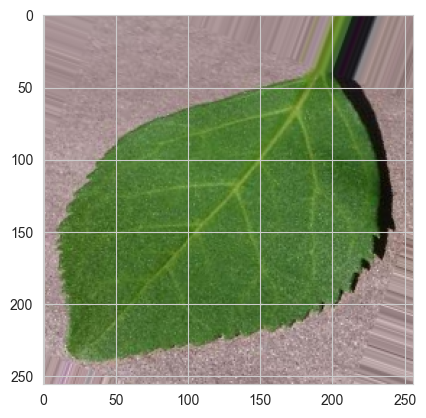

(20, 256, 256, 3)


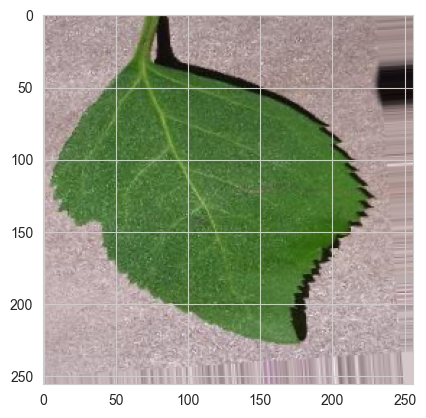

(20, 256, 256, 3)


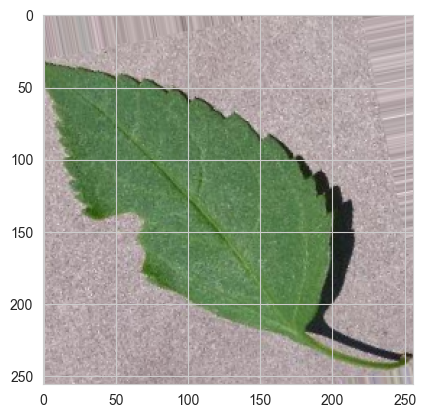

In [53]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation and test images

(20, 256, 256, 3)


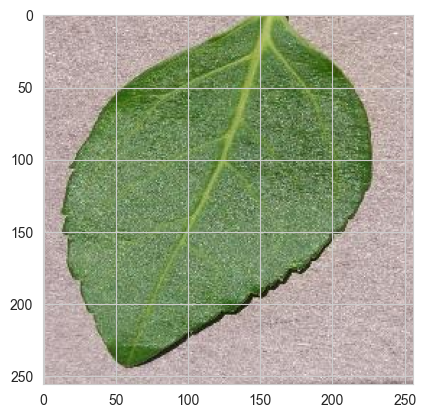

(20, 256, 256, 3)


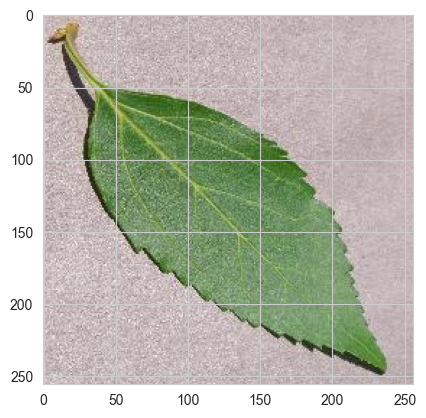

(20, 256, 256, 3)


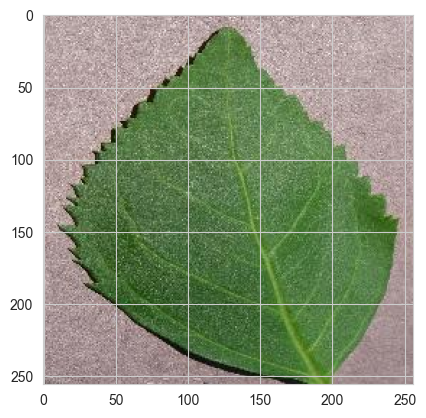

In [54]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


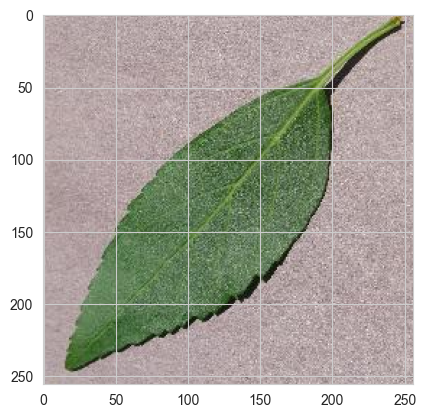

(20, 256, 256, 3)


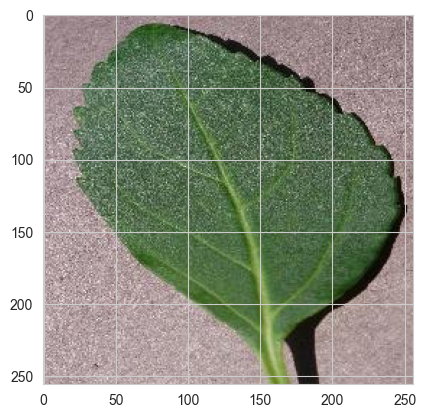

(20, 256, 256, 3)


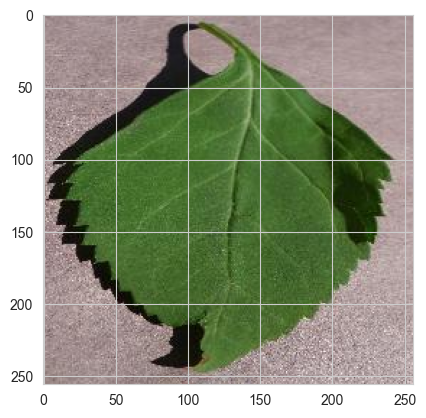

In [55]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

---

## Model creation - Softmax activation function

### Importing model packages

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

As a base ML model, we go with a Convolutional Neural Network, using Tensorflow's Sequential model. 
We will use 

In [57]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(2, 2),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(2, 2),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(2, 2),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model


### Model Summary

In [58]:
create_tf_model().summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 255, 255, 16)      208       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 126, 126, 32)      2080      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 62, 62, 32)        4128      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 30752)            

### Early Stopping

In order to not overfit our model, we add a function to stop the training of the model early.

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fitting the model for training

In [60]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
147/147 [==============================] - 65s 441ms/step - loss: 0.6438 - accuracy: 0.6235 - val_loss: 0.5683 - val_accuracy: 0.8619
Epoch 2/25
147/147 [==============================] - 62s 418ms/step - loss: 0.5210 - accuracy: 0.8081 - val_loss: 0.4041 - val_accuracy: 0.8405
Epoch 3/25
147/147 [==============================] - 65s 439ms/step - loss: 0.3874 - accuracy: 0.8697 - val_loss: 0.2674 - val_accuracy: 0.9262
Epoch 4/25
147/147 [==============================] - 66s 449ms/step - loss: 0.3015 - accuracy: 0.8912 - val_loss: 0.2431 - val_accuracy: 0.9095
Epoch 5/25
147/147 [==============================] - 69s 466ms/step - loss: 0.2470 - accuracy: 0.9220 - val_loss: 0.1754 - val_accuracy: 0.9500
Epoch 6/25
147/147 [==============================] - 67s 454ms/step - loss: 0.2014 - accuracy: 0.9405 - val_loss: 0.1771 - val_accuracy: 0.9452
Epoch 7/25
147/147 [==============================] - 63s 429ms/step - loss: 0.1735 - accuracy: 0.9518 - val_loss: 0.1019 - val_ac

### Save the model

In [61]:
model.save('outputs/v4/mildew_detector_model-softmax.h5')

---

# Model Performance

There are several different ways to assess the performance of our model. 

## Model learning curve

First, we can assess the model learning curve. We look at the loss and accuracy of our train set and validation set. We want the loss to get smaller over the epochs and the accuracy to get higher over the epochs. In an ideal model, the loss of the train set will tend to 0 and the accuracy of the train set will tend to 1, and the loss and accuracy of the validation set will have a very similar progression. 

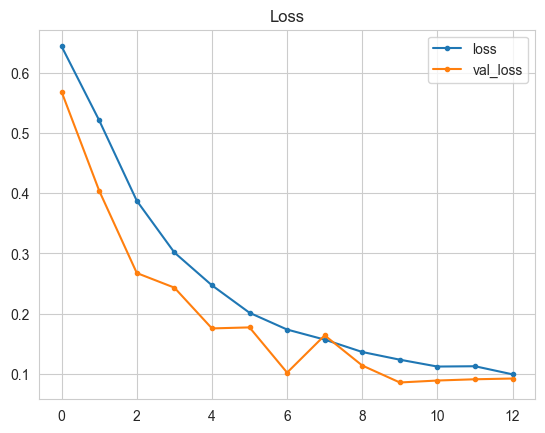

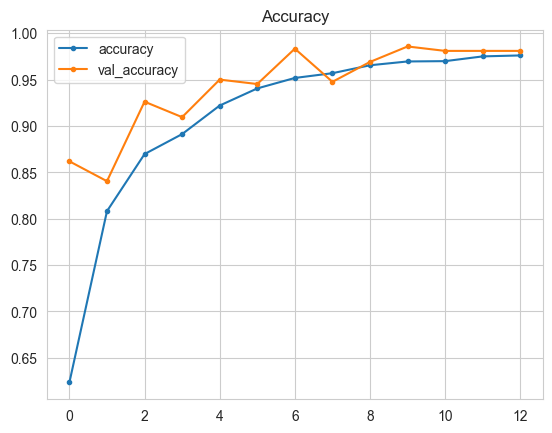

In [62]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{output_path}/model_training_losses-softmax.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{output_path}/model_training_acc-softmax.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Next we can evaluate the absolute loss and accuracy of the model using the keras library and run it on unseen data, i.e. our labelled test set. 

We load the model we saved earlier:

In [64]:
from keras.models import load_model
model = load_model('outputs/v4/mildew_detector_model-softmax.h5')

We evaluate the model on the test set:

In [65]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 3s 68ms/step - loss: 0.1010 - accuracy: 0.9810


We save the evaluation as a .pkl file:

In [66]:
joblib.dump(value=evaluation,
            filename=f"outputs/v4/evaluation-softmax.pkl")

['outputs/v4/evaluation-softmax.pkl']

## Predict on new data

As a manual confirmation, we try if the prediction is accurate on any image we load.

We load any image from our test set (code is adapted and adjusted from the CI Malaria walkthrough):

Image shape: (256, 256), Image mode: RGB


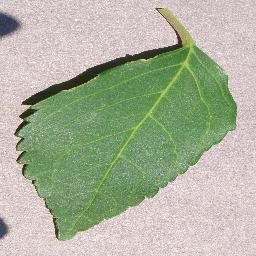

In [104]:
from tensorflow.keras.preprocessing import image

pointer = 24
label = labels[1]  # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

We need to convert the image to an array using numpy:

In [105]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


And then we predict the class probability:

In [106]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.99983203
healthy


---

## Conclusion of comparison for Hypothesis 4

In comparison to the base model, the model using the Softmax activation function needed 5 epochs less to train and finished training after about 14 minutes. The loss and accuracy plots look a bit better than those of the base model. The accuracy of the model lands at 98.1%, which is clearly fitting our business requirement and is exactly the same as the base model. 

When trying the predictions on random images from the test set, the prediction probability seems to be consistently high. 

There doesn't seem to be a significant difference in performance between the base model and the model using the Softmax activation function for the output layer. 